In [1]:
import neuro_morpho_toolbox as nmt

import os
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn import metrics
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import SimpleITK as sitk

sns.set(rc = mpl.rc_params())
%matplotlib inline


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.56
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 3.33


In [2]:
mpl.rc_params()

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [3]:
red = np.array([255,0,0])
green = np.array([0,255,0])
blue = np.array([0,0,255])
orange = np.array([255,105,0])
purple = np.array([160,32,240])
brown = np.array([160,82,45])

## Get cell list

In [4]:
path = "/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/"
group = "MG"
target = "AUDp"
tid = nmt.bs.get_all_child_id(nmt.bs.name_to_id(target))
print([nmt.bs.id_to_name(i) for i in tid])

distal_thres = 0.8
midline = nmt.annotation.micron_size['z']/2
z_max = nmt.annotation.micron_size['z']
x_max = nmt.annotation.micron_size['x']
y_max = nmt.annotation.micron_size['y']


['AUDp', 'AUDp1', 'AUDp2/3', 'AUDp4', 'AUDp5', 'AUDp6a', 'AUDp6b']


In [5]:
[ns] = pickle.load(open("neuron_set_1741cells.pickle", 'rb'))

metadata = ns.metadata.copy()
metadata = metadata[metadata['Manually_corrected_soma_region'].isin([group])]
metadata.rename(columns={'Transgenic_line':'creline',
                         'Brain_id':'brain',     
                         'Subclass_or_type':'cluster'
                        }, inplace=True)
metadata['creline'] = [i.split('-')[0] for i in metadata['creline'].tolist()]
metadata = metadata[['brain', 'creline']]
nlist = metadata.index.tolist()

metadata.head()


,brain,creline
17302_00035,17302,Tnnt1
17302_00036,17302,Tnnt1
17302_00038,17302,Tnnt1
17302_00052,17302,Tnnt1
17302_00076,17302,Tnnt1


In [6]:
def total_length(swc):
    cswc = swc.copy()
    clist = cswc[cswc['parent'].isin(cswc.index)].index.tolist()
    plist = cswc.loc[clist, 'parent'].tolist()
    res = np.sum(np.square(np.array(cswc.loc[clist, ['x', 'y', 'z']]) - 
                           np.array(cswc.loc[plist, ['x', 'y', 'z']])), axis=1)
    res = np.sum(np.sqrt(res))
    return res

## Soma

In [7]:
soma_df = ns.features['soma_features'].raw_data.copy()
soma_df = soma_df.loc[nlist, ['x', 'y', 'z']]
soma_df.head()

,x,y,z
17302_00035,8310.200,3935.600,3721.450
17302_00036,8154.425,3756.500,3597.475
17302_00038,8388.175,3522.800,3365.700
17302_00052,8289.050,3454.400,3805.725
17302_00076,8003.025,4318.575,3581.700


## Axon

In [8]:
def get_node_regions(swc, scale=1/25):
    cswc = swc.copy()
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']] * scale
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']].round(0).astype(int)
    cswc['region'] = 0
    idlist = cswc[((cswc.x>0) & (cswc.x<nmt.annotation.array.shape[0]) &
                   (cswc.y>0) & (cswc.y<nmt.annotation.array.shape[1]) &
                   (cswc.z>0) & (cswc.z<nmt.annotation.array.shape[2])
                  )].index.tolist()
    cswc.loc[idlist, 'region'] = nmt.annotation.array[cswc.x, cswc.y, cswc.z]
    cswc['region'] = cswc['region'].astype(int)
    return cswc

def get_center(swc, silent=True):
    df = swc.copy()[['x', 'y', 'z']]
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    # exclude outliers
    md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
    tp = df[md>1000] # define outliers
    outlier_ratio = len(tp) / len(df) * 100
    if not silent:            
        if outlier_ratio>10:
            print("%.2f%% arbor excluded." % (outlier_ratio))
    df.drop(index=tp.index, inplace=True)
    # Re-center
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    return cid, outlier_ratio
 

ca = ns.neurons[nlist[0]].swc.copy()
ca['region'] = get_node_regions(ca)['region']
ca = ca[ca.region.isin(tid)]
cc, outlier_ratio = get_center(ca, False)
# cc = ca.loc[cc]
# cc

In [9]:
axon_dict = {}
nlist_selected = []
axon_df = pd.DataFrame(index=nlist, columns=['x', 'y', 'z', 'length'])
for i in nlist:
    cswc = ns.neurons[i].swc.copy()
    cswc = cswc[cswc.type==2]
    cswc['region'] = get_node_regions(cswc)['region']
    cswc = cswc[cswc.region.isin(tid)]
    cswc = cswc[cswc.parent.isin(cswc.index)]
    if len(cswc)>0:
        cc, outlier_ratio = get_center(cswc, True)
        cc = cswc.loc[cc]
    cl = total_length(cswc)/1000
    if cl < 1:
        print('%s:\t%.2fmm' % (i, cl))
    else:
        nlist_selected.append(i)
        axon_dict.update({i:cswc})
        axon_df.loc[i, ['x', 'y', 'z', 'length']] = cc[['x', 'y', 'z']].tolist()+[cl]

print(len(nlist), len(nlist_selected))

17545_00162:	0.00mm
18454_00062:	0.79mm
18454_01092:	0.65mm
18454_01093:	0.00mm
18457_00069:	0.58mm
18457_00075:	0.00mm
18462_00022:	0.67mm
18464_00029:	0.58mm
18465_00146:	0.22mm
18465_00152:	0.22mm
50 40


## distance soma v.s. axon

In [10]:
%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



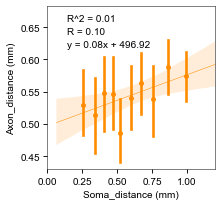

In [11]:
iu = np.triu_indices(len(nlist_selected), k=1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)
axon_dist = sklearn.metrics.pairwise_distances(axon_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_distance (mm)':axon_dist[:,0],
                  })/1000

lm = sklearn.linear_model.LinearRegression()
lm.fit(soma_dist, axon_dist)
r2 = lm.score(soma_dist, axon_dist)
c1 = lm.coef_
c2 = lm.intercept_
r = np.corrcoef(soma_dist[:,0], axon_dist[:,0])[0,1]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_distance (mm)",
                data=df, 
                x_bins=10,
                order=1, 
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15},
                x_jitter=.1)
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05
ax.set_xlim((0,1.2))
ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.79, "y = %.2fx + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top'})

fig.savefig("../Figure/soma_axon_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_distance_"+group+"_v2.pickle", 'wb'))

## Axon overlaps

Merging child region AUDp into region AUDp
Merging child region AUDp1 into region AUDp
Merging child region AUDp2/3 into region AUDp
Merging child region AUDp4 into region AUDp
Merging child region AUDp5 into region AUDp
Merging child region AUDp6a into region AUDp
Merging child region AUDp6b into region AUDp
Loading time for region AUDp : 8.34


(6725.0, 9175.0) (1525.0, 3950.0) (75.0, 2375.0)
x steps:	32
y steps:	32
z steps:	30
17302_00035 17302_00036
0.08604550978471295


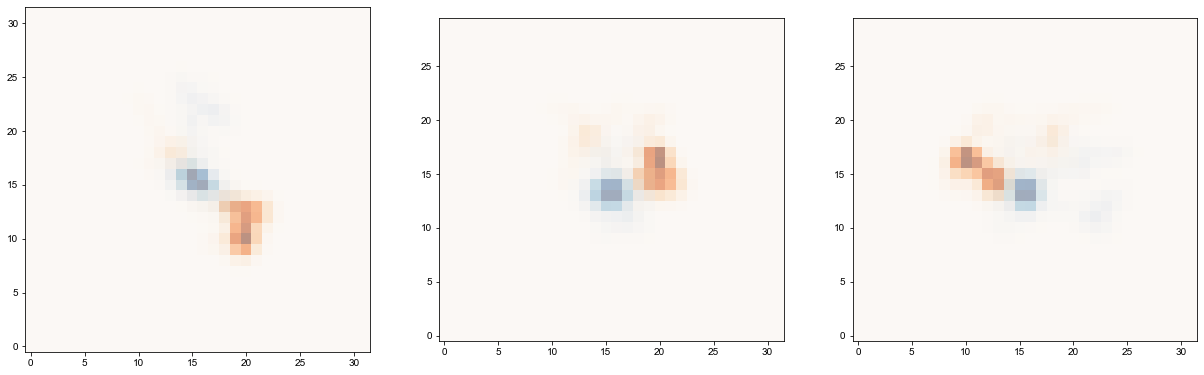

In [12]:
# Get subvolumn
region_id = nmt.bs.name_to_id(target)
tp = nmt.mergeROI([region_id], nmt.annotation.array)
tp[:,:,int(midline/25):] = 0
tp = np.where(tp==region_id)
xlim = (np.max([np.min(tp[0])*25.0 - 500, 0]), 
        np.min([np.max(tp[0])*25.0 + 500, x_max]))
ylim = (np.max([np.min(tp[1])*25.0 - 500, 0]), 
        np.min([np.max(tp[1])*25.0 + 500, y_max]))
zlim = (np.max([np.min(tp[2])*25.0 - 500, 0]), 
        np.min([np.max(tp[2])*25.0 + 500, z_max]))


print(xlim, ylim, zlim)

step_size = 75
x_steps = int((xlim[1]-xlim[0])/step_size)
y_steps = int((ylim[1]-ylim[0])/step_size)
z_steps = int((zlim[1]-zlim[0])/step_size)
print("x steps:\t%d\ny steps:\t%d\nz steps:\t%d" % (x_steps, y_steps, z_steps))

def density_estimation(cur_name, x_steps=20, y_steps=20, plot=True):
    z = axon_dict[cur_name].swc.copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y']])

    p = np.zeros((x_steps, y_steps))
    xs = np.linspace(xlim[0], xlim[1], num=x_steps)
    ys = np.linspace(ylim[0], ylim[1], num=y_steps)
    for i in range(x_steps):
        for j in range(y_steps):
            p[i,j] = np.exp(kde.score(np.array([xs[i], ys[j]]).reshape(1,2)))
    p = p
    p = p / np.sum(p)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(p)
    return p

def density_estimation_3d(cur_name, x_steps=20, y_steps=20, z_steps=20, plot=True):
    z = axon_dict[cur_name].copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y', 'z']])

    p = np.zeros((x_steps, y_steps, z_steps))
    tp = np.where(p==0)
    tp = np.hstack([tp[0].reshape(-1,1), 
                    tp[1].reshape(-1,1),
                    tp[2].reshape(-1,1)
                   ])*step_size+np.array([xlim[0], ylim[0], zlim[0]]).reshape(1,-1)
    p = np.exp(kde.score_samples(tp)).reshape(x_steps, y_steps, z_steps, order="C")
    p = p / np.sum(p)
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(np.transpose(np.max(p, axis=2)), origin='lower', cmap='Reds', alpha=0.75, aspect='equal')
    return p

def get_overlap(p1, p2):
    res = np.zeros(p1.shape)
    # Calculate the frequency under curve
    lab = np.where(p1>=p2)
    res[lab] = p2[lab]
    lab = np.where(p1<p2)
    res[lab] = p1[lab]
    return np.sum(res)


# 3D version
neuron_1 = nlist[0]
neuron_2 = nlist[1]
p1 = density_estimation_3d(neuron_1, x_steps, y_steps, z_steps, False)
p2 = density_estimation_3d(neuron_2, x_steps, y_steps, z_steps, False)

print(neuron_1, neuron_2)
print(get_overlap(p1, p2))

fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(np.transpose(np.max(p1, axis=2)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[0].imshow(np.transpose(np.max(p2, axis=2)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[1].imshow(np.transpose(np.max(p1, axis=1)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[1].imshow(np.transpose(np.max(p2, axis=1)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[2].imshow(np.transpose(np.max(p1, axis=0)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[2].imshow(np.transpose(np.max(p2, axis=0)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')


## Axon overlaps v.s. Soma distance

In [13]:
p_dict = {}
for cur_name in nlist_selected[:]:
    p_dict[cur_name] = density_estimation_3d(cur_name, x_steps, y_steps, z_steps, False)

overlap_df = pd.DataFrame(index=nlist_selected, columns=nlist_selected)
for i in nlist_selected[:]:
    for j in nlist_selected[:]:
        overlap_df.loc[i,j] = get_overlap(p_dict[i], p_dict[j])

In [14]:
overlap_df

,17302_00035,17302_00036,17302_00038,17302_00052,17302_00076,17302_00077,17302_00079,17545_00081,17545_00082,17545_00163,...,18463_00032,18463_00061,18463_00062,18463_00072,18464_00079,18464_00080,18465_00145,18465_00300,18465_00302,18465_00312
17302_00035,1,0.0860455,0.0467492,0.0705236,0.0917657,0.155685,0.0672967,0.0141979,0.0230877,0.000328129,...,0.0160916,0.000730283,0.144193,0.277693,0.158161,0.0340053,0.0749466,4.12794e-05,0.00225817,0.0217031
17302_00036,0.0860455,1,0.0076057,0.00113044,0.0514757,0.0580173,0.0286829,0.000165417,0.0403467,0.002768,...,0.0759073,0.0421782,0.229024,0.161979,0.219031,0.0652369,0.000852985,0.00328829,0.0115847,0.00848062
17302_00038,0.0467492,0.0076057,1,0.152292,0.00414855,0.0054417,0.167744,0.0235177,0.0128621,0.0644748,...,0.00794731,0.0139268,0.0153994,0.0266102,0.090728,0.148842,0.040656,0.0621569,0.016614,0.0266732
17302_00052,0.0705236,0.00113044,0.152292,1,2.26961e-06,0.000248116,0.0214997,0.0144543,0.0181408,0.00496847,...,1.24714e-05,0.00623303,0.00987131,0.0309825,0.0760548,0.0175313,0.0263464,0.00367643,0.000918921,0.0214557
17302_00076,0.0917657,0.0514757,0.00414855,2.26961e-06,1,0.511462,0.0102392,1.17021e-06,0.400577,0.0267389,...,0.414308,0.150879,0.0474804,0.208172,0.0521906,0.182106,0.000151141,0.0144808,0.146374,5.98952e-05
17302_00077,0.155685,0.0580173,0.0054417,0.000248116,0.511462,1,0.00467297,8.44665e-08,0.178299,0.00154987,...,0.325056,0.114107,0.0624768,0.229227,0.0312699,0.130381,0.00221233,0.00296137,0.0345319,0.000501294
17302_00079,0.0672967,0.0286829,0.167744,0.0214997,0.0102392,0.00467297,1,0.113982,0.00712057,0.04051,...,0.000467015,0.00308945,0.0535392,0.0416864,0.184493,0.0668112,0.0958841,0.0161422,0.0244549,0.0473526
17545_00081,0.0141979,0.000165417,0.0235177,0.0144543,1.17021e-06,8.44665e-08,0.113982,1,1.89086e-05,1.11609e-09,...,2.30309e-08,2.64701e-06,0.025976,0.0111956,0.0314318,9.39751e-05,0.132253,2.0836e-05,4.17528e-10,0.23791
17545_00082,0.0230877,0.0403467,0.0128621,0.0181408,0.400577,0.178299,0.00712057,1.89086e-05,1,0.0163946,...,0.221526,0.309153,0.0008718,0.0327175,0.0542516,0.0967147,0.00010554,0.0154442,0.248355,0.000129053
17545_00163,0.000328129,0.002768,0.0644748,0.00496847,0.0267389,0.00154987,0.04051,1.11609e-09,0.0163946,1,...,0.0011311,0.0301447,6.72748e-07,0.00185703,0.0194155,0.3883,8.82141e-06,0.437377,0.225681,4.21391e-07


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



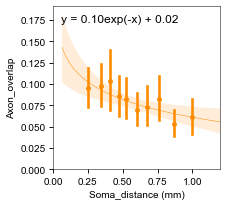

In [15]:
iu = np.triu_indices(len(nlist_selected[:]), 1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)/1000
axon_over = np.array(overlap_df)[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_overlap':axon_over[:,0],
                   'Neuron_1':[nlist_selected[i] for i in iu[0]],
                   'Neuron_2':[nlist_selected[i] for i in iu[1]],
                  }
                 )
df = df.astype({'Soma_distance (mm)':float, 
                   'Axon_overlap':float,
                   'Neuron_1':str,
                   'Neuron_2':str,
                  }
              )


fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_overlap",
                data=df, 
                x_bins=10,
                order=1, 
                logx=True,
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15})
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlim((0,1.2))
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05

lm = sklearn.linear_model.LinearRegression()
ind = df[((df['Soma_distance (mm)']>xlim[0]) & (df['Soma_distance (mm)']<xlim[1]))].index.tolist()
lm.fit(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
       df.loc[ind, ['Axon_overlap']])
c1 = lm.coef_
c2 = lm.intercept_
# r2 = lm.score(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
#               df.loc[ind, ['Axon_overlap']])  # coefficient of determination
# ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
# ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.95, "y = %.2fexp(-x) + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top', 'fontsize':12})


fig.savefig("../Figure/soma_axonoverlap_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_overlap_"+group+"_v2.pickle", 'wb'))